In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir("drive")
os.chdir("My Drive")
os.chdir("Colab Notebooks")
os.chdir("new_upload_Aditya")
os.listdir()

['followers.csv',
 'users.csv',
 'user_follower.csv',
 'aps-inset1.pdf',
 'aps-inset_3.pdf',
 'aps-inset.pdf',
 'df_trim.csv',
 'in_deg_freq.csv',
 'out_deg_freq.csv',
 'all_in_deg.csv',
 'all_out_deg.csv',
 'degreedistribution.png',
 'networkgrowth.png',
 'plot-network-growth.ipynb',
 'avfoll.pdf',
 'UserFol.ipynb',
 'Degree_Distribution.ipynb']

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import networkx as nx  
import pandas as pd
import numpy as np
from scipy import sparse
import gc

## Utility functions
Utility functions created to process data from long dictionaries.

>### degree_freq(G)

<br>**PARAMETERS:** G (graph) – A NetworkX graph.
<br>
<br>**RETURNS:**
<br>in_deg_freq --> Dictionary of Indegree values (as keys) and the number of nodes that have that indegree  (as a value).
<br>out_deg_freq --> Dictionary of Outdegree values (as keys) and the number of nodes that have that outdegree (as a value).
<br>all_in_deg --> Dictionary of all nodes, with their indegree as value (native function of NetworkX does not return a dictionary)
<br> all_out_deg --> Dictionary of all nodes, with their outdegree as value (native function of NetworkX does not return a dictionary)
<br>
<br>**RETURN TYPE:** dictionary


In [0]:
def degree_freq(graph):
    in_deg_freq = {}
    all_in_deg ={}

    out_deg_freq = {}
    all_out_deg ={}
    
    for n in graph.nodes():
        in_deg = graph.in_degree(n)
        out_deg= graph.out_degree(n)
        
        all_in_deg[n] = in_deg
        all_out_deg[n]= out_deg
        
        if in_deg not in in_deg_freq:
            in_deg_freq[in_deg] = 0
        in_deg_freq[in_deg]+= 1
        
        if out_deg not in out_deg_freq:
            out_deg_freq[out_deg] = 0
        out_deg_freq[out_deg]+= 1      
    
    return in_deg_freq, all_in_deg, out_deg_freq, all_out_deg

>### get_top_values(d, t)

Given a dictionary, this function orders it by the value (descending order) and returns a smaller dictionary with the N-top values with their keys.
**PARAMETERS:** 
<br> d (dictionary) – a dictionary with un-ordered values
<br> t (int) – the number of top values to retrieve
<br>**RETURNS:**
<br> new_d --> Dictionary with ordered keys, with highest values.
<br>**RETURN TYPE:** dictionary


In [0]:
def get_top_values(d, t):
    new_d={}
    sorted_keys = sorted(d, key=d.get, reverse=True)
    for x in sorted_keys[:t]:
        new_d[x] = d[x]
    return new_d

>### get_top_keys(D,top)

Given a dictionary, this function orders it by the key (descending order) and returns a list of tuples, with the N-top keys and their values.
**PARAMETERS:** 
<br> D (dictionary) – a dictionary with un-ordered keys
<br> top (int) – the number of n top values 
<br>**RETURNS:**
<br> item --> List of tuples (key,value)
<br>**RETURN TYPE:** list


In [0]:
def get_top_keys(dictionary, top):
    item = list(reversed(sorted(dictionary.items())))
    return item[:top]

## Load dataset of users & followers
For this purpose, we are using the files *followers.csv* and *users.csv*, contained in the MySQL dump that is published by **The GHTorrent project**.
<br>The file *followers.csv* contains three columns, containing the date of creation of the link and the user IDs, indicating if a user follows another. In graphs and network theory, this type of table it is know as "adjacency list". 
<br>
<br>The file *users.csv* contains several columns with user information(user name, id, creation of the account, country, company, email, etc). We use this table only to map the relationship between *user ID number* and *login name*.
<br>
<br>The used tables contain all users ( and their relationships) that were created **until January 2019**.
<br>
<br>__[Link to download the MySQL dump: mysql-2019-01-01.tar.gz (size of 90.1 GB)](http://ghtorrent-downloads.ewi.tudelft.nl/mysql/mysql-2019-01-01.tar.gz)__

In [0]:
#LOAD DATA FROM CSV, only load the first two columns
file_path1 = r'followers.csv'
df_f = pd.read_csv(file_path1, index_col=False, header=None, usecols=[0,1], error_bad_lines=False, warn_bad_lines=False, names=['follower_id', 'user_id'])

In [0]:
#LOAD DATA FROM CSV, only load the required columns
file_path2 = r'users.csv'
df_u = pd.read_csv(file_path2, sep=',', header=None, index_col=False, error_bad_lines=False, warn_bad_lines=False)

In [36]:
#We need to cut the columns we are not going to use and change the header of the dataframe
df_u.columns = ['id', 'login','company','created_at','type','fake','deleted','long','lat','country_code','state','city','location']
cols_to_keep = ['id', 'login','type', 'fake', 'deleted']
df_u = df_u[cols_to_keep]
df_u.head()

,id,login,type,fake,deleted
0,-1,0xnoone,USR,0,1.0
1,1,tosch,USR,0,0.0
2,2,jmettraux,USR,0,0.0
3,3,SMGNMSKD,USR,1,1.0
4,4,kennethkalmer,USR,0,0.0


In [37]:
len(df_u)

29542941

In [38]:
user_df = df_u.loc[(df_u['type'] == 'USR') & (df_u['deleted'] == 0.0) & (df_u['fake'] == 0)]
len(user_df)
user_df.head()

20497145

,id,login,type,fake,deleted
1,1,tosch,USR,0,0.0
2,2,jmettraux,USR,0,0.0
4,4,kennethkalmer,USR,0,0.0
5,5,weppos,USR,0,0.0
6,6,anb,USR,0,0.0


In [39]:
df_u['fake'].value_counts()

0    22419796
1     7123145
Name: fake, dtype: int64

In [22]:
df_u['deleted'].value_counts()

 0.000000     28486025
 1.000000      1056913
 12.493823           1
 23.301001           1
-4.202646            1
Name: deleted, dtype: int64

In [23]:
#we are not considering the ORG (organization accounts) and the ones labeled with 0 (innactive accounts)
df_ORG = df_u.loc[ df_u['type']=='ORG']
df_zero = df_u.loc[ df_u['type']=='0']
df_fake = df_u.loc[df_u['fake']=='1']
df_deleted = df_u.loc[df_u['deleted']== 0.000000]
df_deleted_12 = df_u.loc[df_u['deleted']== 12.493823]
df_deleted_23 = df_u.loc[df_u['deleted']== 23.301001]
df_deleted_neg = df_u.loc[df_u['deleted']== -4.202646]


# we don't need this columns
del df_ORG['login']
del df_ORG['type']
del df_zero['login']
del df_zero['type']
gc.collect()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


139

In [0]:
print("Number of users:", df_u.shape[0])

Number of users: 29542941


In [0]:
import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)


[('df_u', 3968749740),
 ('df_f', 476955960),
 ('df_ORG', 18589624),
 ('InteractiveShell', 1056),
 ('degree_freq', 136),
 ('df_zero', 136),
 ('get_top_keys', 136),
 ('get_top_values', 136),
 ('cols_to_keep', 88),
 ('drive', 80),
 ('np', 80),
 ('nx', 80),
 ('pd', 80),
 ('plt', 80),
 ('sparse', 80),
 ('file_path1', 62)]

In [0]:
# 1 - delete nodes from the 'user_id' col, that are ZERO type
df_trim = df_f[~df_f.user_id.isin(df_zero.id)]

# delete nodes form the 'follower_id' col, that are ZERO type
df_trim = df_trim[~df_trim.follower_id.isin(df_zero.id)]

In [26]:
# 3 - delete nodes that are ORG type
df_trim = df_trim[~df_trim.user_id.isin(df_ORG.id)]
df_trim = df_trim[~df_trim.follower_id.isin(df_ORG.id)]
len(df_trim['user_id'].unique())
df_trim.shape[0]

3775490

29583654

In [27]:
# 3 - delete nodes that are ORG type
df_trim = df_trim[~df_trim.user_id.isin(df_fake.id)]
df_trim = df_trim[~df_trim.follower_id.isin(df_fake.id)]
len(df_trim['user_id'].unique())
df_trim.shape[0]

3775490

29583654

In [29]:

df_trim = df_trim[~df_trim.user_id.isin(df_deleted.id)]
df_trim = df_trim[~df_trim.follower_id.isin(df_deleted.id)]
len(df_trim['user_id'].unique())
df_trim.shape[0]


28895

45322

In [31]:
df_trim = df_trim[~df_trim.user_id.isin(df_deleted_12.id)]
df_trim = df_trim[~df_trim.follower_id.isin(df_deleted_12.id)]
len(df_trim['user_id'].unique())
df_trim.shape[0]


28895

45322

In [32]:
df_trim = df_trim[~df_trim.user_id.isin(df_deleted_23.id)]
df_trim = df_trim[~df_trim.follower_id.isin(df_deleted_23.id)]
len(df_trim['user_id'].unique())
df_trim.shape[0]


28895

45322

In [33]:
df_trim = df_trim[~df_trim.user_id.isin(df_deleted_neg.id)]
df_trim = df_trim[~df_trim.follower_id.isin(df_deleted_neg.id)]
len(df_trim['user_id'].unique())
df_trim.shape[0]

28895

45322

In [0]:
#29,583,654 - edges
df_trim.shape[0]

29583654

In [0]:
#3,775,490 - Users
len(df_trim['user_id'].unique())

3775490

In [0]:
df_trim.head()

,follower_id,user_id
0,1,2
1,1,4
2,1,17896
3,1,21523
4,1,29121


In [0]:
#free memory
del df_u
del df_f
del df_ORG
del df_zero

gc.collect()


11

In [0]:
#save to CSV
df_trim.to_csv('df_trim.csv', header=False, index=False)

In [0]:
#load from CSV
df_trim = pd.read_csv('df_trim.csv', index_col=False, names=['follower_id', 'user_id'])
df_trim.head()

### Preliminar size of full network
Before creating the Network, we can get some preliminary statistic about it:
<br>Number of users = **3,775,490**
<br>Number of edges (connections) = **29,583,654**
<br>
<br>At this point we have not validated if all listed users in file *users.csv* have an entry in *followers.csv*

In [0]:
print("Number of users:", len(df_trim['user_id'].unique()))
print("Number of edges:", df_trim.shape[0])

Number of users: 3775490
Number of edges: 29583654


### Create full network of users

In [0]:
#create empty directed Graph
full_followers_graph = nx.DiGraph()

In [0]:
# the directed graph maps the direction as: [follower --> user]
# for this purpose, the graph is created using the dataframe as a list
full_followers_graph.add_edges_from(df_trim.values.tolist())

In [0]:
# print and check some stats about the full network
print(nx.info(full_followers_graph))

Name: 
Type: DiGraph
Number of nodes: 5351128
Number of edges: 29583654
Average in degree:   5.5285
Average out degree:   5.5285


In [0]:
# calculates some statistics
in_deg_freq, all_in_deg, out_deg_freq, all_out_deg = degree_freq(full_followers_graph)

#save information in csv file

(pd.DataFrame.from_dict(data=in_deg_freq, orient='index').to_csv('in_deg_freq.csv'))
(pd.DataFrame.from_dict(data=all_in_deg,  orient='index').to_csv('all_in_deg.csv'))
(pd.DataFrame.from_dict(data=out_deg_freq,orient='index').to_csv('out_deg_freq.csv'))
(pd.DataFrame.from_dict(data=all_out_deg, orient='index').to_csv('all_out_deg.csv'))

In [0]:
#parses list of indegree values and outdegree values
idf = (sorted(in_deg_freq.items()))
odf = (sorted(out_deg_freq.items()))

<Figure size 1152x712.8 with 0 Axes>

Text(0.5, 0, 'Number of followers')

Text(0, 0.5, 'Number of users')

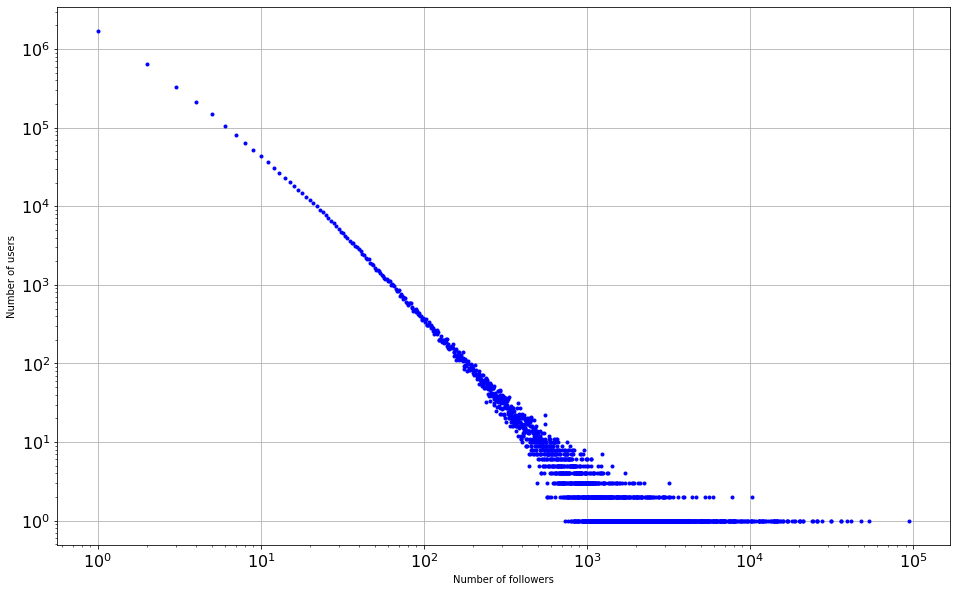

<Figure size 432x288 with 0 Axes>

In [0]:
#plot degree frequency

plt.figure(figsize =(16, 9.9))
plt.grid(True)
plt.loglog([k for (k,v) in idf], [v for (k,v) in idf], 'b.') # in-degree
#plt.loglog([k for (k,v) in odf],[v for (k,v ) in odf], 'b-')  # out-degree
#plt.legend(['In-degree', 'Out-degree'])
plt.xlabel('Number of followers')
plt.ylabel('Number of users')
#plt.title('Followers network in Github')
plt.tick_params(labelsize=16)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('degreedistribution.png')

<Figure size 1152x712.8 with 0 Axes>

Text(0, 0.5, 'Degree')

Text(0.5, 0, 'Number of nodes')

Text(0.5, 1.0, 'Followers network in Github')

Text(0.5, 0.98, 'Average In degreee Vs number of nodes')

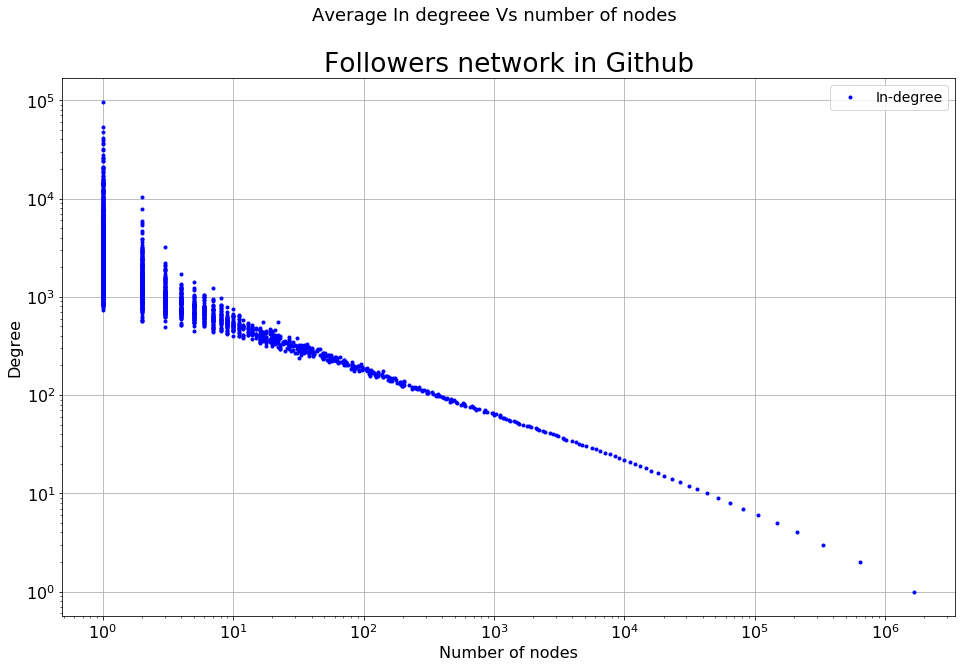

<Figure size 432x288 with 0 Axes>

In [0]:
#plot degree frequency

plt.figure(figsize =(16, 9.9))
plt.grid(True)
plt.loglog( [v for (k,v) in idf],[k for (k,v) in idf], 'b.') # in-degree
#plt.loglog([k for (k,v) in odf],[v for (k,v ) in odf], 'b-')  # out-degree
plt.legend(['In-degree', 'Out-degree'],bbox_to_anchor=(1,1), prop={'size': 14},fontsize = 'xx-large')#(1,1.2)
plt.ylabel('Degree', fontsize=16)
plt.xlabel('Number of nodes', fontsize=16)
plt.title('Followers network in Github')
plt.suptitle('Average In degreee Vs number of nodes', fontsize=18)
plt.tick_params(labelsize=16)
plt.rcParams.update({'font.size': 22})

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('degree_distribution_2019.png')

In [0]:
#save to CSV
df_trim.to_csv('df_trim.csv', header=False, index=False)

In [0]:
#since we are not doing further calculations with this full network, we release the memory 
del full_followers_graph

In [0]:
#use the Garbage collect utility
gc.collect()
gc.collect()

3856

0